In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings(action='ignore')

#### #1. 데이터 로드 및 확인

In [2]:
train_transaction = pd.read_csv('Data/03_Fraud Detection/train_transaction.csv')
train_identity = pd.read_csv('Data/03_Fraud Detection/train_identity.csv')
train_transaction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590540 entries, 0 to 590539
Columns: 394 entries, TransactionID to V339
dtypes: float64(376), int64(4), object(14)
memory usage: 1.7+ GB


In [3]:
train_transaction.columns

Index(['TransactionID', 'isFraud', 'TransactionDT', 'TransactionAmt',
       'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5',
       ...
       'V330', 'V331', 'V332', 'V333', 'V334', 'V335', 'V336', 'V337', 'V338',
       'V339'],
      dtype='object', length=394)

In [4]:
train_identity.columns

Index(['TransactionID', 'id_01', 'id_02', 'id_03', 'id_04', 'id_05', 'id_06',
       'id_07', 'id_08', 'id_09', 'id_10', 'id_11', 'id_12', 'id_13', 'id_14',
       'id_15', 'id_16', 'id_17', 'id_18', 'id_19', 'id_20', 'id_21', 'id_22',
       'id_23', 'id_24', 'id_25', 'id_26', 'id_27', 'id_28', 'id_29', 'id_30',
       'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38',
       'DeviceType', 'DeviceInfo'],
      dtype='object')

In [5]:
# train data 합치기
train = pd.merge(train_transaction, train_identity, on='TransactionID', how='left')
train.head(3)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
print("transcation shape:",train_transaction.shape)
print("identity shape:",train_identity.shape)
print("최종 shape:",train.shape)

transcation shape: (590540, 394)
identity shape: (144233, 41)
최종 shape: (590540, 434)


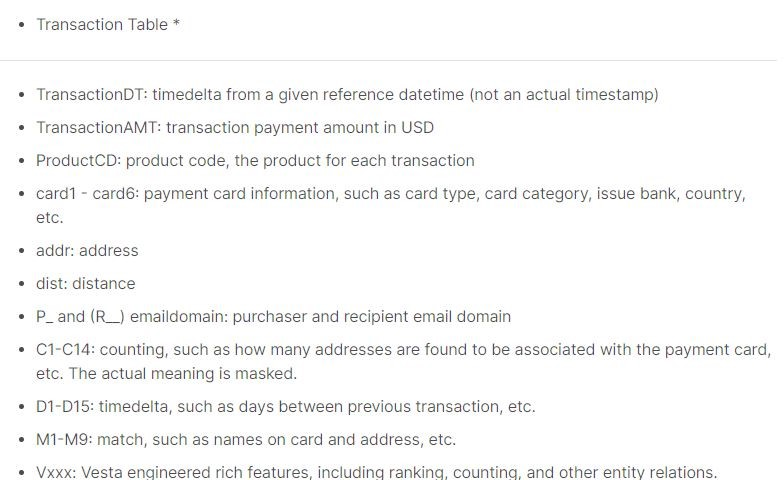

In [8]:
from IPython.display import Image

Image("Data/03_Fraud Detection/#Transaction_Description.jpg")

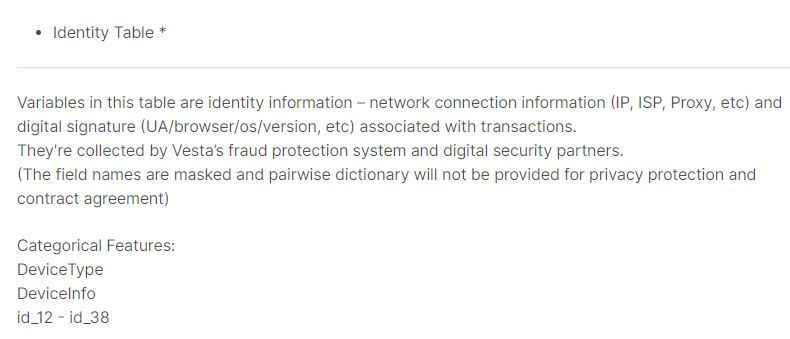

In [9]:
Image("Data/03_Fraud Detection/#Identity_Description.jpg")

#### #2. column 파악하기

column의 수가 매우 많으며 , 그 안에는 의미가 분명하지 않은 column도 존재하므로 해당 column들을 먼저 확인. <br>
확인하며 drop할 column들도 정할 예정.<br>
##### card , counting, timedelta, match, id ,Vxxx

In [10]:
drop_col = []

In [22]:
# 반복되는 작업이 많으므로 함수를 만들어서 사용
def check_col(char,index):
    result = []
    for i in range(1,index+1):
        result.append(char+str(i))
    result_df = pd.DataFrame(train[result])
    
    print(result_df.head(3))
    print('\n\n')
    print(result_df.info())
    print('\n\n')
    print(result_df.isnull().sum())
    
    return result

##### 1) card : card1~card6

In [23]:
card = check_col('card',6)

   card1  card2  card3       card4  card5   card6
0  13926    NaN  150.0    discover  142.0  credit
1   2755  404.0  150.0  mastercard  102.0  credit
2   4663  490.0  150.0        visa  166.0   debit



<class 'pandas.core.frame.DataFrame'>
Int64Index: 590540 entries, 0 to 590539
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   card1   590540 non-null  int64  
 1   card2   581607 non-null  float64
 2   card3   588975 non-null  float64
 3   card4   588963 non-null  object 
 4   card5   586281 non-null  float64
 5   card6   588969 non-null  object 
dtypes: float64(3), int64(1), object(2)
memory usage: 31.5+ MB
None



card1       0
card2    8933
card3    1565
card4    1577
card5    4259
card6    1571
dtype: int64


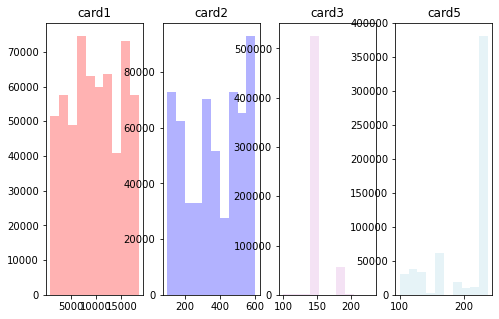

In [25]:
# 숫자형 칼럼의 분포 확인
fig = plt.figure(figsize=[8,5])
card_num = ['card1','card2','card3','card5']
card_df = train[card_num]
color = ['red','blue','plum','lightblue']

for i,card in enumerate(card_num):
    ax_i = fig.add_subplot(1,4,i+1)
    plt.hist(card_df[card],color=color[i],alpha=0.3)
    ax_i.title.set_text(card)

card2은 card1과 분포 형태가 비슷하고 null값이 많으므로 삭제.<br>
card5는 분포가 치우쳐 있으며 null값도 많으므로 삭제.<br>
object형인 card4,card6은 target(isFraud)와 큰 관계가 없다고 판단하여 삭제.

In [26]:
# drop 리스트에 추가 
drop_col.append('card2')
drop_col.append('card4')
drop_col.append('card5')
drop_col.append('card6')

##### 2) counting : C1~C14

In [27]:
counting = check_col('C',14)

    C1   C2   C3   C4   C5   C6   C7   C8   C9  C10  C11  C12  C13  C14
0  1.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0  0.0  2.0  0.0  1.0  1.0
1  1.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  1.0  0.0  1.0  1.0
2  1.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0  0.0  1.0  0.0  1.0  1.0



<class 'pandas.core.frame.DataFrame'>
Int64Index: 590540 entries, 0 to 590539
Data columns (total 14 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   C1      590540 non-null  float64
 1   C2      590540 non-null  float64
 2   C3      590540 non-null  float64
 3   C4      590540 non-null  float64
 4   C5      590540 non-null  float64
 5   C6      590540 non-null  float64
 6   C7      590540 non-null  float64
 7   C8      590540 non-null  float64
 8   C9      590540 non-null  float64
 9   C10     590540 non-null  float64
 10  C11     590540 non-null  float64
 11  C12     590540 non-null  float64
 12  C13     590540 non-null  float64
 13  C14     590540 non-null

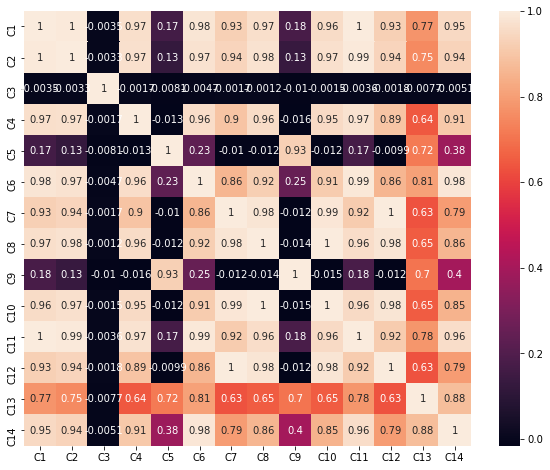

In [28]:
# 모든 칼럼에 Null값이 없으나 칼럼들의 의미가 불분명하므로 칼럼들의 상관관계 확인
plt.figure(figsize=(10,8))
counting_df = train[counting]
counting_corr = counting_df.corr()
sns.heatmap(counting_corr,annot=True)
plt.show()

변수들 간의 상관관계가 높으므로 차원을 축소시켜 알고리즘에 적용시키기로 결정

##### 3) timedelta : D1~D15

In [29]:
timedelta = check_col('D',15)

     D1  D2    D3   D4  D5  D6  D7  D8  D9   D10    D11  D12  D13  D14    D15
0  14.0 NaN  13.0  NaN NaN NaN NaN NaN NaN  13.0   13.0  NaN  NaN  NaN    0.0
1   0.0 NaN   NaN  0.0 NaN NaN NaN NaN NaN   0.0    NaN  NaN  NaN  NaN    0.0
2   0.0 NaN   NaN  0.0 NaN NaN NaN NaN NaN   0.0  315.0  NaN  NaN  NaN  315.0



<class 'pandas.core.frame.DataFrame'>
Int64Index: 590540 entries, 0 to 590539
Data columns (total 15 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   D1      589271 non-null  float64
 1   D2      309743 non-null  float64
 2   D3      327662 non-null  float64
 3   D4      421618 non-null  float64
 4   D5      280699 non-null  float64
 5   D6      73187 non-null   float64
 6   D7      38917 non-null   float64
 7   D8      74926 non-null   float64
 8   D9      74926 non-null   float64
 9   D10     514518 non-null  float64
 10  D11     311253 non-null  float64
 11  D12     64717 non-null   float64
 12  D13     61952 non-null   float64
 13 

모든 칼럼에 null값이 비교적 많이 존재.<br>
칼럼의 특별한 의미를 알 수 없고, TransactionDT 칼럼 또한 timedelta를 다루고 있으므로 timedelta칼럼은 모두 사용하지 않고 drop

In [30]:
# drop 리스트에 추가
for i in range(0,15):
    drop_col.append(timedelta[i])

##### 4) match : M1~M9

In [31]:
match = check_col('M',9)

    M1   M2   M3  M4 M5 M6   M7   M8   M9
0    T    T    T  M2  F  T  NaN  NaN  NaN
1  NaN  NaN  NaN  M0  T  T  NaN  NaN  NaN
2    T    T    T  M0  F  F    F    F    F



<class 'pandas.core.frame.DataFrame'>
Int64Index: 590540 entries, 0 to 590539
Data columns (total 9 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   M1      319440 non-null  object
 1   M2      319440 non-null  object
 2   M3      319440 non-null  object
 3   M4      309096 non-null  object
 4   M5      240058 non-null  object
 5   M6      421180 non-null  object
 6   M7      244275 non-null  object
 7   M8      244288 non-null  object
 8   M9      244288 non-null  object
dtypes: object(9)
memory usage: 45.1+ MB
None



M1    271100
M2    271100
M3    271100
M4    281444
M5    350482
M6    169360
M7    346265
M8    346252
M9    346252
dtype: int64


timedelta와 마찬가지로 모든 칼럼에 null값이 비교적 많이 존재하며<br>
칼럼의 특별한 의미를 알 수 없으므로 match칼럼 또한 모두 사용하지 않고 drop

In [32]:
# drop 리스트에 추가
for i in range(0,9):
    drop_col.append(match[i])

##### 5) id

In [34]:
# 해당 칼럼은 숫자가 00형식이므로 다른 방법 사용
id = []
column = train.columns
for col in column:
    if 'id' in col:
        id.append(col)
id_df = train[id]

In [35]:
print(id_df.head(3))
print('\n\n')
print(id_df.info())
print('\n\n')
print(id_df.isnull().sum())

   id_01  id_02  id_03  id_04  id_05  id_06  id_07  id_08  id_09  id_10  ...  \
0    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN  ...   
1    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN  ...   
2    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN  ...   

   id_29 id_30  id_31  id_32 id_33 id_34  id_35  id_36  id_37  id_38  
0    NaN   NaN    NaN    NaN   NaN   NaN    NaN    NaN    NaN    NaN  
1    NaN   NaN    NaN    NaN   NaN   NaN    NaN    NaN    NaN    NaN  
2    NaN   NaN    NaN    NaN   NaN   NaN    NaN    NaN    NaN    NaN  

[3 rows x 38 columns]



<class 'pandas.core.frame.DataFrame'>
Int64Index: 590540 entries, 0 to 590539
Data columns (total 38 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   id_01   144233 non-null  float64
 1   id_02   140872 non-null  float64
 2   id_03   66324 non-null   float64
 3   id_04   66324 non-null   float64
 4   id_05   136865 non-null  

대부분의 값이 NaN이므로 사용하지 않고 drop

In [36]:
# drop 리스트에 추가
for i in range(0,len(id)):
    drop_col.append(id[i])

##### 6) Vxxx

In [37]:
Vcol = check_col('V',339)

    V1   V2   V3   V4   V5   V6   V7   V8   V9  V10  ...  V329  V330  V331  \
0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0  ...   NaN   NaN   NaN   
1  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...   NaN   NaN   NaN   
2  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0  ...   NaN   NaN   NaN   

   V332  V333  V334  V335  V336  V337  V338  
0   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
1   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
2   NaN   NaN   NaN   NaN   NaN   NaN   NaN  

[3 rows x 338 columns]



<class 'pandas.core.frame.DataFrame'>
Int64Index: 590540 entries, 0 to 590539
Columns: 338 entries, V1 to V338
dtypes: float64(338)
memory usage: 1.5 GB
None



V1      279287
V2      279287
V3      279287
V4      279287
V5      279287
         ...  
V334    508189
V335    508189
V336    508189
V337    508189
V338    508189
Length: 338, dtype: int64


대부분의 값이 NaN이며 의미를 파악하기 어려우므로 사용하지 않고 drop

In [38]:
# drop 리스트에 추가
for i in range(0,len(Vcol)):
    drop_col.append(Vcol[i])

#### #3. 데이터 시각화

In [39]:
# 칼럼 drop 및 target 분리 
y_data = train['isFraud']
train_drop = train.drop(drop_col,axis=1)
train_drop = train_drop.drop('isFraud',axis=1)

In [40]:
train_drop.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 590540 entries, 0 to 590539
Data columns (total 29 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   TransactionID   590540 non-null  int64  
 1   TransactionDT   590540 non-null  int64  
 2   TransactionAmt  590540 non-null  float64
 3   ProductCD       590540 non-null  object 
 4   card1           590540 non-null  int64  
 5   card3           588975 non-null  float64
 6   addr1           524834 non-null  float64
 7   addr2           524834 non-null  float64
 8   dist1           238269 non-null  float64
 9   dist2           37627 non-null   float64
 10  P_emaildomain   496084 non-null  object 
 11  R_emaildomain   137291 non-null  object 
 12  C1              590540 non-null  float64
 13  C2              590540 non-null  float64
 14  C3              590540 non-null  float64
 15  C4              590540 non-null  float64
 16  C5              590540 non-null  float64
 17  C6        

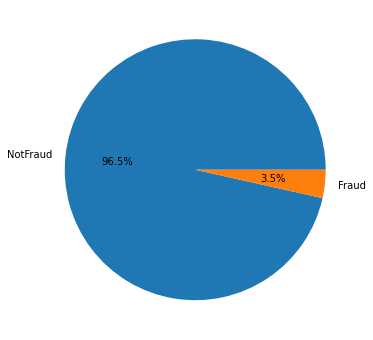

In [48]:
# target label 확인
labels = ['NotFraud','Fraud']
isFraud = y_data.value_counts()

plt.figure(figsize=(6,6))
plt.pie(labels=labels,x=isFraud,autopct='%1.1f%%')
plt.show()

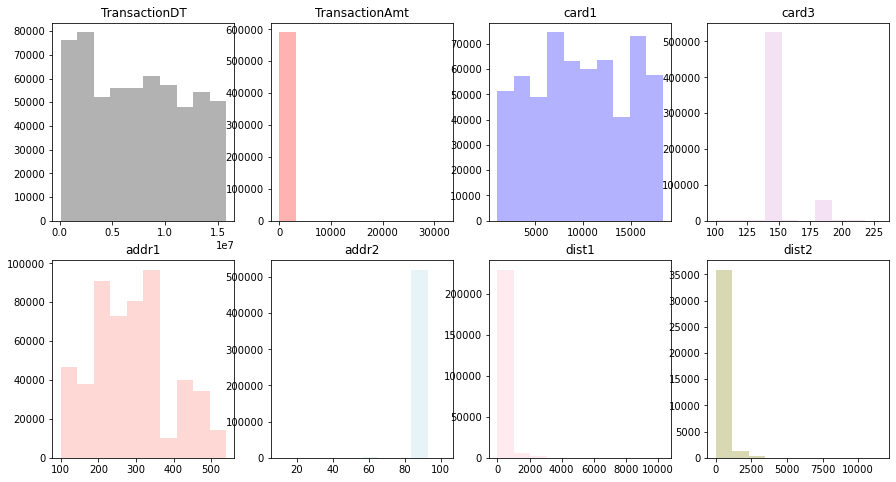

In [42]:
# 이후 PCA를 진행할 Counting 칼럼,object 칼럼을 제외하고 분포 확인

column = ['TransactionDT','TransactionAmt','card1','card3','addr1','addr2','dist1','dist2']
color = ['black','red','blue','plum','salmon','lightblue','pink','olive','purple','indigo','lightcoral','darkgreen','yellow','peru']

fig = plt.figure(figsize=(15,8))
for i,col in enumerate(column):
    ax_i = fig.add_subplot(2,4,i+1)
    plt.hist(train_drop[col],color=color[i],alpha=0.3)
    ax_i.title.set_text(col)

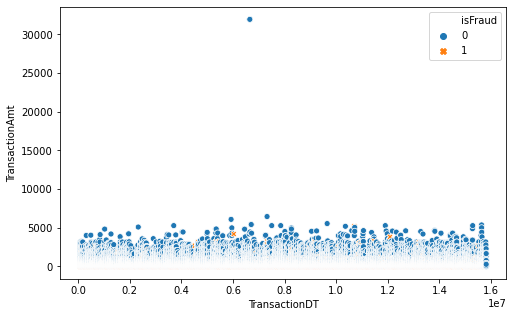

In [44]:
# 가장 영향력을 많이 미칠 것 같은 TransactionDT , TransactionAmt 시각화
fig = plt.figure(figsize=(8,5))
sns.scatterplot(x='TransactionDT',y='TransactionAmt',hue=y_data,style=y_data,data=train_drop)
plt.show()

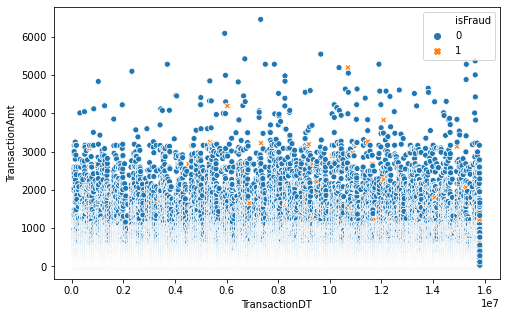

In [45]:
# 시각화 결과가 제대로 파악되지 않으므로 outlier 제거 후 다시 시각화
train_drop.loc[train_drop['TransactionAmt']>30000,'TransactionAmt'] = 0 
fig = plt.figure(figsize=(8,5))
sns.scatterplot(x='TransactionDT',y='TransactionAmt',hue=y_data,style=y_data,data=train_drop)
plt.show()

TransactionDT 칼럼과 TransactionAmt 칼럼 모두 특별한 경향성은 찾아볼 수 없는 것으로 판단<br>

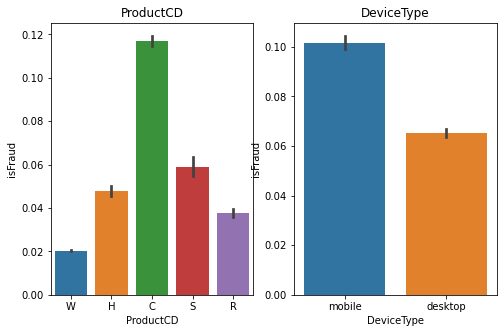

In [46]:
# 카테코리 형 칼럼의 분포 확인
# 종류가 많은 칼럼(P_emaildomain,R_emaildomain,DeviceInfo) 제외
object_col = ['ProductCD','DeviceType']

fig = plt.figure(figsize=(8,5))
for i,col in enumerate(object_col):
    ax_i = fig.add_subplot(1,2,i+1)
    sns.barplot(x=train_drop[col],y=y_data)
    ax_i.title.set_text(col)

#### #4. 알고리즘 적용

In [47]:
# 앞서 제거하지 않았던 칼럼 제거
# id는 고유 정보로 분석에 불필요하다고 판단되며, emaildomain,deviceinfo 또한  특별히 분석에 영행을 주지 않는 다고 판단  
x_data = train_drop.drop(['TransactionID','P_emaildomain','R_emaildomain','DeviceInfo'],axis=1)

# PCA 적용을 위해 counting 칼럼 분리
counting = []
for i in range(1,15):
    counting.append('C'+str(i))
counting_df= train[counting]
x_data = x_data.drop(counting,axis=1)
print(x_data.shape)

(590540, 11)


In [49]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_counting = scaler.fit_transform(counting_df)

In [50]:
# counting 칼럼 PCA 적용
from sklearn.decomposition import PCA
pca = PCA(n_components=8)
pca_result = pca.fit(scaled_counting)
columns = pd.DataFrame(scaled_counting).columns

Result = ['Variance','Variance%','Cum%']
result_pc = np.transpose(np.array(pca_result.components_).reshape(np.shape(pca_result.components_)))
result_var = np.array(np.transpose(pca_result.explained_variance_[:,np.newaxis]))
result_varp = np.array(np.transpose(pca_result.explained_variance_ratio_[:,np.newaxis]))
result_sum = np.cumsum(np.round(pca_result.explained_variance_ratio_,decimals=8)*100)
result_varc = np.array(np.transpose(result_sum[:,np.newaxis]))
result_df = pd.DataFrame(np.concatenate((result_pc,result_var,result_varp,result_varc),axis=0),
                         index=np.concatenate((np.array(columns),Result)),
                         columns=['PC1','PC2','PC3','PC4','PC5','PC6','PC7','PC8'])
result_df

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8
0,0.312872,-0.012861,0.000275,0.098886,0.051721,0.286331,0.472420,-0.461688
1,0.312509,-0.040477,-0.000232,0.065011,0.023154,0.204761,0.515092,0.662301
2,-0.001278,-0.009280,0.999955,0.000031,0.001583,0.000041,0.000235,0.000344
3,0.301791,-0.123570,-0.000631,0.361508,-0.165040,-0.020420,-0.144496,0.032528
4,0.060245,0.610036,0.006727,-0.182131,-0.624979,0.421031,-0.140826,0.044993
5,0.307845,0.042970,0.000243,0.347036,0.048067,0.031369,-0.160833,0.071241
6,0.295558,-0.141157,-0.001146,-0.478559,0.068018,0.036862,-0.148897,-0.089554
7,0.305645,-0.137927,-0.000405,-0.153082,-0.024008,0.028432,-0.108459,-0.254319
8,0.061569,0.609958,0.004600,-0.086521,0.722637,0.089681,-0.099153,0.077801
9,0.304412,-0.138115,-0.000715,-0.194545,-0.028813,-0.177162,-0.423203,0.428686


In [51]:
# 97% 설명력을 가진 PC3까지 선택
pca = PCA(n_components=3) 
pca_result = pca.fit_transform(scaled_counting)
pca_counting = pd.DataFrame(data=pca_result, columns = ['Counting_PC1','Counting_PC2','Counting_PC3'])

In [52]:
# 카테고리형 칼럼 인코딩
x_data = pd.get_dummies(x_data,columns=['ProductCD','DeviceType'])

In [53]:
# null값 처리
print(x_data.isnull().sum())

TransactionDT              0
TransactionAmt             0
card1                      0
card3                   1565
addr1                  65706
addr2                  65706
dist1                 352271
dist2                 552913
V339                  508189
ProductCD_C                0
ProductCD_H                0
ProductCD_R                0
ProductCD_S                0
ProductCD_W                0
DeviceType_desktop         0
DeviceType_mobile          0
dtype: int64


In [54]:
# null값이 가장 많은 dist2 칼럼은 분포도 dist1 칼럼과 큰 차이를 보이지 않았으므로 삭제
# 나머지 null값들은 일단 평균값으로 대체
x_data.drop('dist2',axis=1,inplace=True)
x_data['card3'].fillna(x_data['card3'].mean(),inplace=True)
x_data['addr1'].fillna(x_data['addr1'].mean(),inplace=True)
x_data['addr2'].fillna(x_data['addr2'].mean(),inplace=True)
x_data['dist1'].fillna(x_data['dist1'].mean(),inplace=True)

In [57]:
# x_data와 PCA진행 한 칼럼 통합
x_data = pd.concat([x_data,pca_counting],axis=1)

In [59]:
# 데이터 분리
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x_data,y_data,test_size=0.2,random_state=0,stratify=y_data)

In [60]:
# 스케일링
model_scaler = StandardScaler()
scaled_x_train = model_scaler.fit_transform(x_train)
scaled_x_test = model_scaler.transform(x_test)

##### 1) 로지스틱 회귀

In [87]:
# 로지스틱 회귀 적용 및 C값 튜닝 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
c_range = [0.01,0.1,1,10]

accuracy = []
for c in c_range:
    model = LogisticRegression(C=c)
    model.fit(scaled_x_train,y_train)
    predict = model.predict(scaled_x_test)
    accuracy.append(accuracy_score(y_test,predict))
print("c",c_range)
print("accuracy",accuracy)

c [0.01, 0.1, 1, 10]
accuracy [0.9650066041250381, 0.9650066041250381, 0.9650066041250381, 0.9650066041250381]


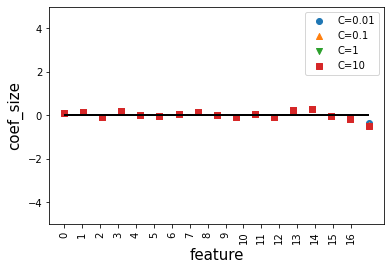

In [88]:
# C값에 따른 정확도의 변화가 보이지 않으므로 시각화로 확인
# 출처 : https://woolulu.tistory.com/22
c_range = [0.01,0.1,1,10]
n_feature = scaled_x_train.shape[1]
line = np.linspace(0,n_feature,num=n_feature).reshape(-1,1)
marker_set = ['o', '^', 'v','s']

for c_args,m in zip(c_range,marker_set):
    params = {'C':c_args}
    model = LogisticRegression(**params).fit(scaled_x_train,y_train)
    plt.scatter(line,model.coef_,marker=m,label='C={}'.format(c_args))
    
plt.hlines(0,xmin=np.min(line),xmax=n_feature,lw=2,color='k')
plt.xticks(np.arange(n_feature),(pd.DataFrame(scaled_x_train)).columns,rotation=90,ha='center')
plt.ylim(-5,5)
plt.xlabel('feature',size=15)
plt.ylabel('coef_size',size=15)
plt.legend(loc=1)
plt.show()

In [89]:
# C값에 영향을 받지 않는 것으로 보여, default값으로 학습
model = LogisticRegression()
model.fit(scaled_x_train,y_train)
predict = model.predict(scaled_x_test)

In [90]:
from sklearn.metrics import classification_report
print(classification_report(y_test,predict))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98    113975
           1       0.00      0.00      0.00      4133

    accuracy                           0.97    118108
   macro avg       0.48      0.50      0.49    118108
weighted avg       0.93      0.97      0.95    118108



In [91]:
# 정확도 확인
print("학습세트:",model.score(scaled_x_train,y_train))
print("테스트세트:",accuracy_score(y_test,predict))

학습세트: 0.9649981372980662
테스트세트: 0.9650066041250381


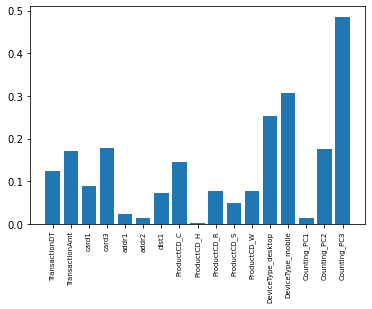

In [92]:
# 추가적으로 피처별 중요도 확인
model.fit(scaled_x_train,y_train)
feature_importance = np.abs(model.coef_[0])
label = [col for col in x_train.columns]
index = np.arange(len(label))
plt.bar([x for x in range(len(feature_importance))],feature_importance)
plt.xticks(index, label, fontsize=7,rotation=90)
plt.show()

##### 2) KNN

In [93]:
# KNN 적용 
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier()
model.fit(scaled_x_train,y_train)
predict = model.predict(scaled_x_test)

In [94]:
print("학습세트:",model.score(scaled_x_train,y_train))
print("테스트세트:",accuracy_score(y_test,predict))
print(classification_report(y_test,predict))

학습세트: 0.9760769803908287
테스트세트: 0.9689860128018424
              precision    recall  f1-score   support

           0       0.98      0.99      0.98    113975
           1       0.62      0.30      0.41      4133

    accuracy                           0.97    118108
   macro avg       0.80      0.65      0.70    118108
weighted avg       0.96      0.97      0.96    118108



In [ ]:
# 적절한 K값 찾기

train_accuracy=[]
test_accuracy=[]

for n in range(1,10):
    model = KNeighborsClassifier(n_neighbors=n)
    model.fit(scaled_x_train,y_train)
    predict = model.predict(scaled_x_test)
    train_accuracy.append(model.score(scaled_x_train,y_train))
    test_accuracy.append(accuracy_score(y_test,predict))

In [ ]:
plt.figure(figsize=(5,5))
plt.plot(range(1, 10), train_accuracy, label='TRAIN set')
plt.plot(range(1, 10), test_accuracy, label='TEST set')
plt.xlabel("n_neighbors")
plt.ylabel("accuracy")
plt.xticks(np.arange(0, 16, step=1)) #그래프의 눈금 
plt.legend()

##### 3) RandomForest

In [95]:
# RandomForest 적용
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier()
model.fit(scaled_x_train,y_train)
predict = model.predict(scaled_x_test)

In [96]:
print("학습세트:",model.score(scaled_x_train,y_train))
print("테스트세트:",accuracy_score(y_test,predict))
print(classification_report(y_test,predict))

학습세트: 0.999993649879771
테스트세트: 0.981728587394588
              precision    recall  f1-score   support

           0       0.98      1.00      0.99    113975
           1       0.93      0.52      0.66      4133

    accuracy                           0.98    118108
   macro avg       0.96      0.76      0.83    118108
weighted avg       0.98      0.98      0.98    118108



In [ ]:
# 하이퍼 파라미터 튜닝 

##### 4) SVC

In [ ]:
# SVC 적용
from sklearn import svm

model= svm.SVC(kernel='sigmoid')
model.fit(scaled_x_train,y_train)
predict = model.predict(scaled_x_test)

In [ ]:
print("학습세트:",model.score(scaled_x_train,y_train))
print("테스트세트:",accuracy_score(y_test,predict))
print(classification_report(y_test,predict))

In [ ]:
# 하이퍼 파라미터 튜닝 

데이터의 크기가 커서 그런지, 알고리즘을 적용하는데 시간이 상당히 오래 걸렸다.<br>
SVC도 적용해보고 싶었으나 10시간 가까이 돌려도 완료되지 않아 포기 했다. <br>
소모되는 시간이 조금만 짧았다면 알고리즘 튜닝도 해서 성능을 높일 수 있지 않았을까 하는 아쉬움이 남는다.<br>
해당 데이터의 특성 상 레이블 1의 경우를 판별하는 것이 중요한데,<br>
적용한 3가지 알고리즘 중에서 가장 성능이 좋은 랜덤 포레스트 또한 그다지 높은 성능이 아닌 것이 아쉽다.<br>
조금 더 좋은 환경에서 다시 한 번 학습 시키고 싶다.<br>

#### #5. 최종 테스트 데이터에 적용 후 제출(RandomForest)

In [67]:
test_transaction = pd.read_csv('Data/03_Fraud Detection/test_transaction.csv')
test_identity = pd.read_csv('Data/03_Fraud Detection/test_identity.csv')
test = pd.merge(test_transaction, test_identity, on='TransactionID', how='left')

In [68]:
print("최종 shape:",test.shape)
print("null값",test.isnull().sum())

최종 shape: (506691, 433)
null값 TransactionID          0
TransactionDT          0
TransactionAmt         0
ProductCD              0
card1                  0
                   ...  
id-36             369714
id-37             369714
id-38             369714
DeviceType        369760
DeviceInfo        391634
Length: 433, dtype: int64


In [69]:
test_ID = test['TransactionID']

In [70]:
for col in drop_col:
    if 'id' in col:
        drop_col.remove(col)
print(drop_col)

['card2', 'card4', 'card5', 'card6', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29', 'V30', 'V31', 'V32', 'V33', 'V34', 'V35', 'V36', 'V37', 'V38', 'V39', 'V40', 'V41', 'V42', 'V43', 'V44', 'V45', 'V46', 'V47', 'V48', 'V49', 'V50', 'V51', 'V52', 'V53', 'V54', 'V55', 'V56', 'V57', 'V58', 'V59', 'V60', 'V61', 'V62', 'V63', 'V64', 'V65', 'V66', 'V67', 'V68', 'V69', 'V70', 'V71', 'V72', 'V73', 'V74', 'V75', 'V76', 'V77', 'V78', 'V79', 'V80', 'V81', 'V82', 'V83', 'V84', 'V85', 'V86', 'V87', 'V88', 'V89', 'V90', 'V91', 'V92', 'V93', 'V94', 'V95', 'V96', 'V97', 'V98', 'V99', 'V100', 'V101', 'V102', 'V103', 'V104', 'V105', 'V106', 'V107', 'V108', 'V109', 'V110', 'V111', 'V112', 'V113', 'V114', 'V115', '

In [71]:
column = test.columns
for col in column:
    if 'id' in col:
        drop_col.append(col)
        
drop_col.append('TransactionID')
drop_col.append('P_emaildomain')
drop_col.append('R_emaildomain')
drop_col.append('DeviceInfo')
drop_col.append('dist2')

test_drop = test.drop(drop_col,axis=1)
print(test_drop.shape)

(506691, 23)


In [72]:
counting = []
for i in range(1,15):
    counting.append('C'+str(i))
counting_df= test_drop[counting]
test_drop = test_drop.drop(counting,axis=1)
print(test_drop.shape)

(506691, 9)


In [75]:
print(counting_df.isnull().sum())

C1        3
C2        3
C3        3
C4        3
C5        3
C6        3
C7        3
C8        3
C9        3
C10       3
C11       3
C12       3
C13    4748
C14       3
dtype: int64


In [76]:
for col in counting_df:
    counting_df[col].fillna(counting_df[col].mean(),inplace=True)

In [77]:
scaler = StandardScaler()
scaled_counting = scaler.fit_transform(counting_df)

In [78]:
pca = PCA(n_components=3) 
pca_result = pca.fit_transform(scaled_counting)
pca_counting = pd.DataFrame(data=pca_result, columns = ['Counting_PC1','Counting_PC2','Counting_PC3'])

In [79]:
test_drop = pd.get_dummies(test_drop,columns=['ProductCD','DeviceType'])

In [80]:
test_drop['card3'].fillna(test_drop['card3'].mean(),inplace=True)
test_drop['addr1'].fillna(test_drop['addr1'].mean(),inplace=True)
test_drop['addr2'].fillna(test_drop['addr2'].mean(),inplace=True)
test_drop['dist1'].fillna(test_drop['dist1'].mean(),inplace=True)

In [81]:
print(test_drop.isnull().sum())

TransactionDT         0
TransactionAmt        0
card1                 0
card3                 0
addr1                 0
addr2                 0
dist1                 0
ProductCD_C           0
ProductCD_H           0
ProductCD_R           0
ProductCD_S           0
ProductCD_W           0
DeviceType_desktop    0
DeviceType_mobile     0
dtype: int64


In [82]:
test = pd.concat([test_drop,pca_counting],axis=1)

In [83]:
scaled_test = model_scaler.transform(test)

In [85]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier()
model.fit(scaled_x_train,y_train)
predict = model.predict(scaled_test)

submit = pd.DataFrame(test_ID)
submit['isFraud'] = predict

In [86]:
submit.to_csv('C:\\Users\\chltp\\Kaggle\\Data\\03_Fraud Detection\\submit.csv',sep=',',index=False)